# Apperal Recomendation Workshop Exercise

**Objective**: Build a model to get similar products using the features " Title, Brand, Colour, Image ".

**Note:** We are using the pre-processed data, cleaned during the workshop.

In [1]:
# Importing necessary modules for computation.

import math

import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
from matplotlib import gridspec

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import pairwise_distances


# Additional module import for our utility functions.

import requests
from PIL import Image
from io import BytesIO


In [2]:
# Loading PreProcessed data stored in pickle file.

data = pd.read_pickle('pickels/16k_apperal_data_preprocessed')

In [3]:
data.head()

asin                        brand              color  \
4   B004GSI2OS                  FeatherLite  Onyx Black/ Stone   
6   B012YX2ZPI  HX-Kingdom Fashion T-shirts              White   
15  B003BSRPB0                  FeatherLite              White   
27  B014ICEJ1Q                        FNC7C             Purple   
46  B01NACPBG2                 Fifth Degree              Black   

                                     medium_image_url product_type_name  \
4   https://images-na.ssl-images-amazon.com/images...             SHIRT   
6   https://images-na.ssl-images-amazon.com/images...             SHIRT   
15  https://images-na.ssl-images-amazon.com/images...             SHIRT   
27  https://images-na.ssl-images-amazon.com/images...             SHIRT   
46  https://images-na.ssl-images-amazon.com/images...             SHIRT   

                                                title formatted_price  
4   featherlite ladies long sleeve stain resistant...          $26.26  
6   womens unique 100 cotton  special olympics wor...           $9.99  
15  featherlite ladies moisture free mesh sport sh...          $20.54  
27  supernatural chibis sam dean castiel neck tshi...           $7.39  
46  fifth degree womens gold foil graphic tees jun...           $6.95

In [4]:
# Our data contains 7 columns (asin 	brand	color	medium_image_url	product_type_name	title	formatted_price)
# with 16042 rows (data points).

data.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 16042 entries, 4 to 183120
Data columns (total 7 columns):
asin                 16042 non-null object
brand                15997 non-null object
color                16042 non-null object
medium_image_url     16042 non-null object
product_type_name    16042 non-null object
title                16042 non-null object
formatted_price      16042 non-null object
dtypes: object(7)
memory usage: 1002.6+ KB


##### Feature transformation (of brand and color):

In [5]:
# There are no Null values except in the "Brand" column.
# So we replace Null with a string "Not given".

data['brand'].fillna(value="Not given", inplace=True )

# Brand and Colour are our Categorical values
# Some of these are a combination of words, containing spaces which separate them,
# To treat them as a single element, lets replace these spaces with hyphen.

brands = [x.replace(" ", "-") for x in data['brand'].values]
colors = [x.replace(" ", "-") for x in data['color'].values]

In [6]:
# Using One-Hot encoding to get a sparse matrix of the categorical features (Brand, Color).
# Here each row has a value '1' in only at only one column.

brand_features = CountVectorizer().fit_transform(brands)
color_features = CountVectorizer().fit_transform(colors)

print('Brand: ',brand_features.shape)    # Matrix of shape 16042 x 3835
print('Color: ',color_features.shape)    # Matrix of shape 16042 x 1845

Brand:  (16042, 3835)
Color:  (16042, 1845)


##### Image feature Extraction:

In [7]:
# Load VGG-16 CNN Image feature - computed using Keras.

image_features = np.load('drive-download-files/16k_data_cnn_features.npy')

In [8]:
# Loading corresponding asins of image vector.

i_asins = np.load('16k_data_cnn_feature_asins.npy')

# converting it into a list so that it can be indexed.
i_asins = list(i_asins)

In [9]:
# Each image of dimensions (224, 224)
# is converted into a dense vector of length 25088.

print("Image_feature dimension: ",image_features.shape)

Image_feature dimension:  (16042, 25088)


##### Title feature Extraction:

In [10]:
# We use 'idf-Word2Vec' to get a dense matrix of our "Title" feature.
# Each word is initially converted to a vector of length 300,
# Then the words in the title are multiplied with their respective idf weights
# And its average value is calculated to get the Vector of each title.

# Here, we are using Google-News-Word2Vec.

words_w2v = pd.read_pickle('word2vec_model')

In [11]:
vocab = words_w2v.keys()

# Getting a Count Vector of the words in title.

idf_title_vectorizer = CountVectorizer()
idf_title_features = idf_title_vectorizer.fit_transform(data['title'])

# idf_title_features[doc_id, index_of_word_in_corpus] = number of times the word occured in that doc
# idf_title_features dimension = (#number of docs, #number of words in entire corpus)

print(idf_title_features.shape)

(16042, 12609)


In [14]:
# Calculating the idf value of each word.

def n_containing(word):
    # return the number of documents which had the given word
    return sum(1 for blob in data['title'] if word in blob.split())

def idf(word):
    # idf = log(#number of docs / #number of docs which had the given word)
    # total number of docs: 16042
    return math.log( 16042 / (n_containing(word)))

# we need to convert the values into float
idf_title_features  = idf_title_features.astype(np.float)

for i in idf_title_vectorizer.vocabulary_.keys():
    # for every word in whole corpus we will find its idf value
    idf_val = idf(i)
    
    # to calculate idf_title_features we need to replace the count values with the idf values of the word
    # idf_title_features[:, idf_title_vectorizer.vocabulary_[i]].nonzero()[0] will return all documents in which the word i present
    for j in idf_title_features[:, idf_title_vectorizer.vocabulary_[i]].nonzero()[0]:
        
        # we replace the count values of word i in document j with  idf_value of word i 
        # idf_title_features[doc_id, index_of_word_in_courpus] = idf value of word
        idf_title_features[j,idf_title_vectorizer.vocabulary_[i]] = idf_val

In [15]:
# Calculating the w2v of a title.

def build_avg_vec(sentence, doc_id, num_features = 300):
    # sentence: title of the apparel
    # num_features: the lenght of word2vec vector, its values = 300

    featureVec = np.zeros((num_features,), dtype="float32")
    # we will intialize a vector of size 300 with all zeros
    # we add each word2vec(wordi) to this fetureVec
    nwords = 0
    
    for word in sentence.split():
        nwords += 1
        if word in vocab:
            if word in  idf_title_vectorizer.vocabulary_:
                featureVec = np.add(featureVec, idf_title_features[doc_id, idf_title_vectorizer.vocabulary_[word]] * words_w2v[word])
                
    if(nwords>0):
        featureVec = np.divide(featureVec, nwords)
    # returns the avg vector of given sentance, its of shape (1, 300)
    return featureVec

In [16]:
doc_id = 0

# w2v vector of titles.
title_features = []

# for every title we build a weighted vector representation
for i in data['title']:
    title_features.append(build_avg_vec(i, doc_id))
    doc_id += 1
    
# title_features = np.array(# number of doc in courpus * 300), each row corresponds to a doc 
title_features = np.array(title_features)

#### Utility functions to visualize our result.

In [17]:
def display_img(url,ax,fig):
    # we get the url of the apparel and download it
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    # we will display it in notebook 
    plt.imshow(img)

def get_word_vec(sentence, doc_id):
    # sentence : title of the apparel
    # doc_id: document id in our corpus
    
    vec = []
    for i in sentence.split():
        if i in vocab:
            if i in  idf_title_vectorizer.vocabulary_:
                vec.append(idf_title_features[doc_id, idf_title_vectorizer.vocabulary_[i]] * words_w2v[i])
        else:
            # if the word in our courpus is not there in the google word2vec corpus, we are just ignoring it
            vec.append(np.zeros(shape=(300,)))
    # we will return a numpy array of shape (#number of words in title * 300 ) 300 = len(w2v_model[word])
    # each row represents the word2vec representation of each word in given sentance 
    return  np.array(vec)

def get_distance(vec1, vec2):
    # vec1 = np.array(#number_of_words_title1 * 300), each row is a vector of length 300 corresponds to each word in give title
    # vec2 = np.array(#number_of_words_title2 * 300), each row is a vector of length 300 corresponds to each word in give title
    
    final_dist = []
    # for each vector in vec1 we caluclate the distance(euclidean) to all vectors in vec2
    for i in vec1:
        dist = []
        for j in vec2:
            # np.linalg.norm(i-j) will result the euclidean distance between vectors i, j
            dist.append(np.linalg.norm(i-j))
        final_dist.append(np.array(dist))
    # final_dist = np.array(#number of words in title1 * #number of words in title2)
    # final_dist[i,j] = euclidean distance between vectors i, j
    return np.array(final_dist)


def heat_map_w2v_brand(sentance1, sentance2, url, doc_id1, doc_id2, df_id1, df_id2):
    
    # sentance1 : title1, input apparel
    # sentance2 : title2, recommended apparel
    # url: apparel image url
    # doc_id1: document id of input apparel
    # doc_id2: document id of recommended apparel
    # df_id1: index of document1 in the data frame
    # df_id2: index of document2 in the data frame
    
    #s1_vec = np.array(#number_of_words_title1 * 300), each row is a vector(weighted/avg) of length 300 corresponds to each word in give title
    s1_vec = get_word_vec(sentance1, doc_id1)
    #s2_vec = np.array(#number_of_words_title2 * 300), each row is a vector(weighted/avg) of length 300 corresponds to each word in give title
    s2_vec = get_word_vec(sentance2, doc_id2)
    
    # s1_s2_dist = np.array(#number of words in title1 * #number of words in title2)
    # s1_s2_dist[i,j] = euclidean distance between words i, j
    s1_s2_dist = get_distance(s1_vec, s2_vec)
  
    # divide whole figure space into 25 * 1:10 grids
    gs = gridspec.GridSpec(25, 15)
    fig = plt.figure(figsize=(25,5))
    
    # in first 25*10 grids we plot heatmap
    ax1 = plt.subplot(gs[:, :-5])
    # ploting the heap map based on the pairwise distances
    ax1 = sns.heatmap(np.round(s1_s2_dist,6), annot=True)
    # set the x axis labels as recommended apparels title
    ax1.set_xticklabels(sentance2.split())
    # set the y axis labels as input apparels title
    ax1.set_yticklabels(sentance1.split())
    # set title as recommended apparels title
    ax1.set_title(sentance2)

    # in last 25 * 10:15 grids we display image
    ax2 = plt.subplot(gs[:, 10:16])
    # we dont display grid lins and axis labels to images
    ax2.grid(False)
    ax2.set_xticks([])
    ax2.set_yticks([])
    
    # pass the url it display it
    display_img(url, ax2, fig)
    
    plt.show()

### Weighted Recommendation Model
Uses -> *Title*, *Brand*, *Colour* and *Image* as features.
<p> Pass in different weights relative to each other, to check which feature works best. </p>

In [18]:
# Final Model.

def weighted_model(doc_id, w_t, w_b, w_c, w_i, num_results):
    '''
    w_t = weight of title.
    w_b = weight of Brand.
    w_c = weight of colour.
    w_i = weight of Image.
    num_results = Number of recommendations to be displayed.
    '''
    # Calculating Euclidian distances of each feature, with other docs.
    title_feat_dist = pairwise_distances(title_features, title_features[doc_id].reshape(1,-1))
    brand_feat_dist = pairwise_distances(brand_features, brand_features[doc_id])
    color_feat_dist = pairwise_distances(color_features, color_features[doc_id])
    image_feat_dist = pairwise_distances(image_features, image_features[i_asins.index(data['asin'].iloc[doc_id])].reshape(1,-1))
    
    # Applying weights to each feature.
    pairwise_dist   = (w_t * title_feat_dist +  w_b * brand_feat_dist + w_c * color_feat_dist + w_i * image_feat_dist)/float(w_t + w_b + w_c + w_i)

    # np.argsort will return indices of top smallest distances
    indices = np.argsort(pairwise_dist.flatten())[0:num_results]
    #pdists will store the top smallest distances
    pdists  = np.sort(pairwise_dist.flatten())[0:num_results]

    #data frame indices of the top smallest distances
    df_indices = list(data.index[indices])

    for i in range(0, len(indices)):
        heat_map_w2v_brand(data['title'].loc[df_indices[0]],data['title'].loc[df_indices[i]], data['medium_image_url'].loc[df_indices[i]], indices[0], indices[i],df_indices[0], df_indices[i])
        print('ASIN :',data['asin'].loc[df_indices[i]])
        print('Brand :',data['brand'].loc[df_indices[i]])
        print('Color :',data['color'].loc[df_indices[i]])
        print('euclidean distance from input :', pdists[i])
        print('='*125)

### Call the *weighted_model()* function with different values to try it out.

#### 1. Giving title highest weight.

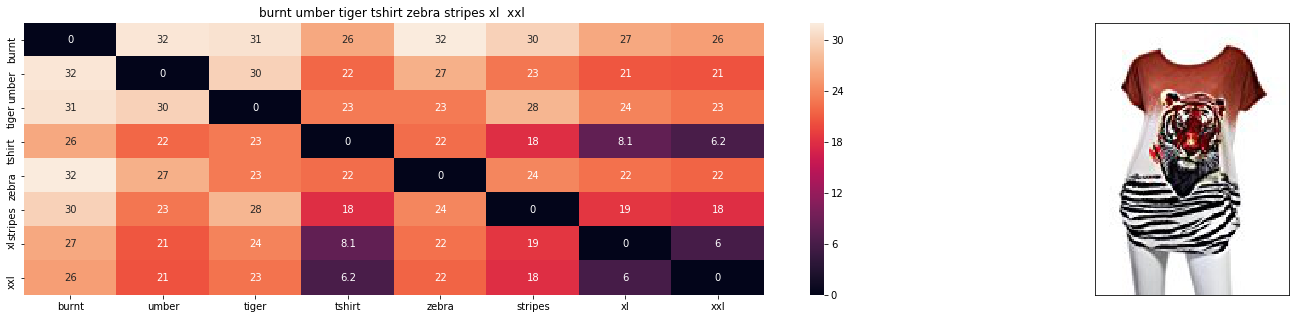

ASIN : B00JXQB5FQ
Brand : Si Row
Color : Brown
euclidean distance from input : 2.5727262237797612


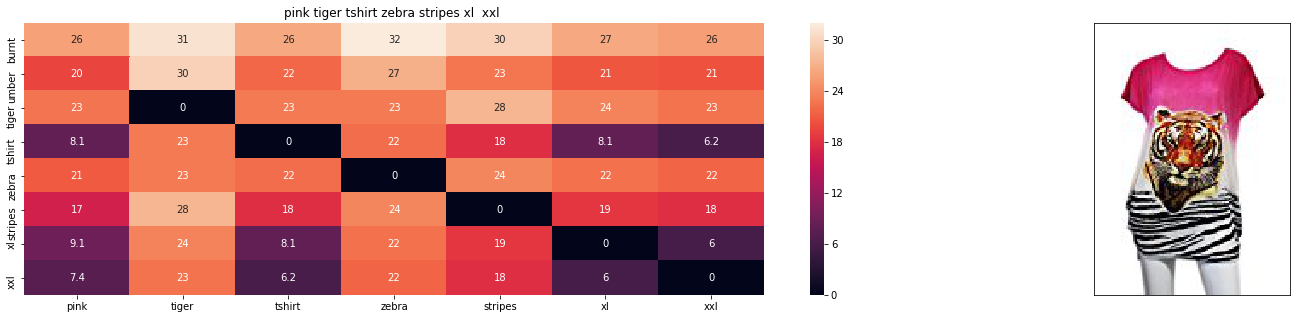

ASIN : B00JXQASS6
Brand : Si Row
Color : Pink
euclidean distance from input : 5.946367114538895


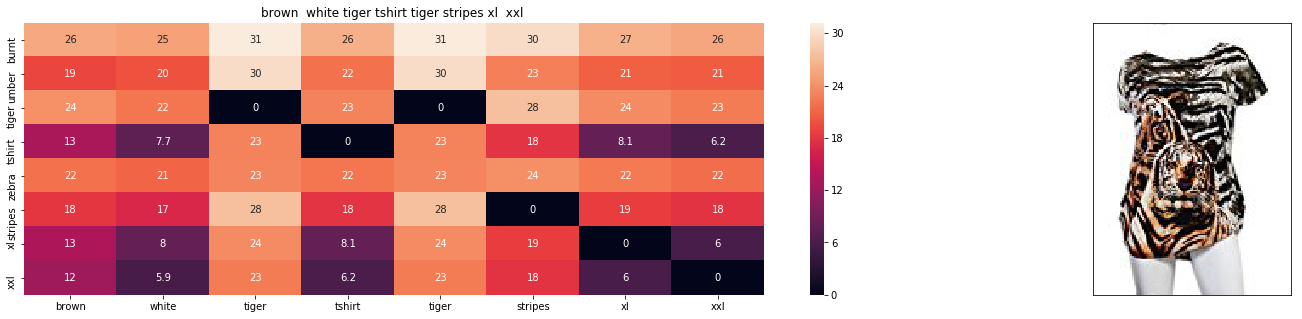

ASIN : B00JXQCWTO
Brand : Si Row
Color : Brown
euclidean distance from input : 6.719765372898268


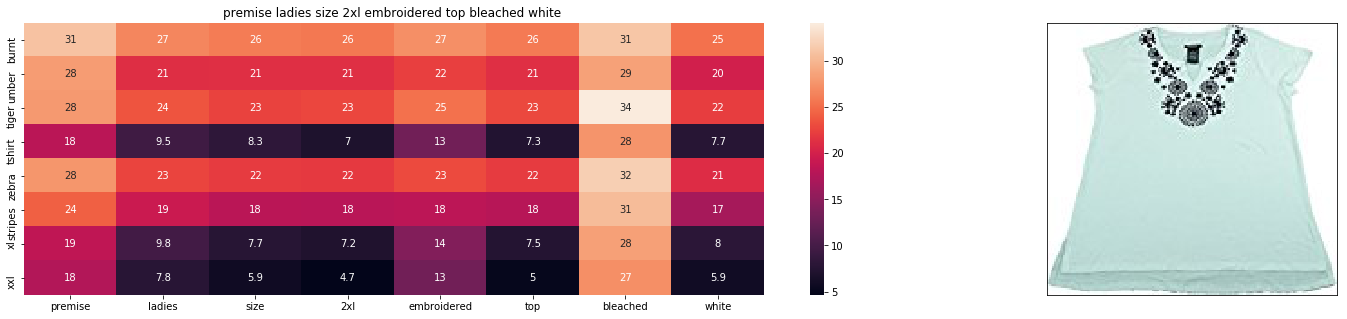

ASIN : B01M0IDUCV
Brand : Premise
Color : Bleached White
euclidean distance from input : 6.833980635568149


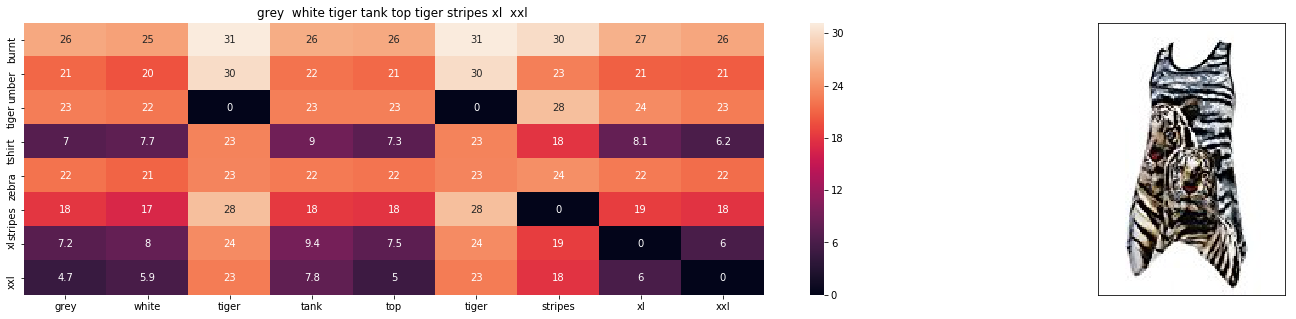

ASIN : B00JXQAFZ2
Brand : Si Row
Color : Grey
euclidean distance from input : 7.304229670001276


In [76]:
weighted_model(12566, 20, 1, 1, 1, 5)

#### 2. Giving Brand highest weight.

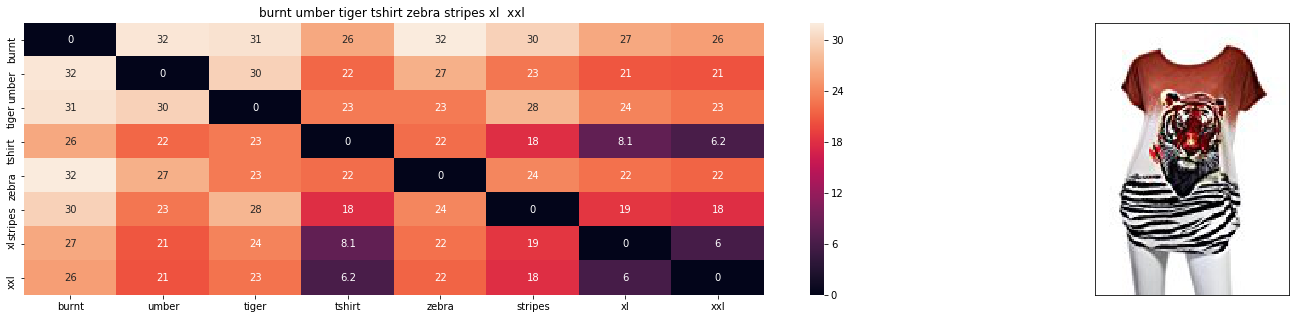

ASIN : B00JXQB5FQ
Brand : Si Row
Color : Brown
euclidean distance from input : 0.0038244957462526285


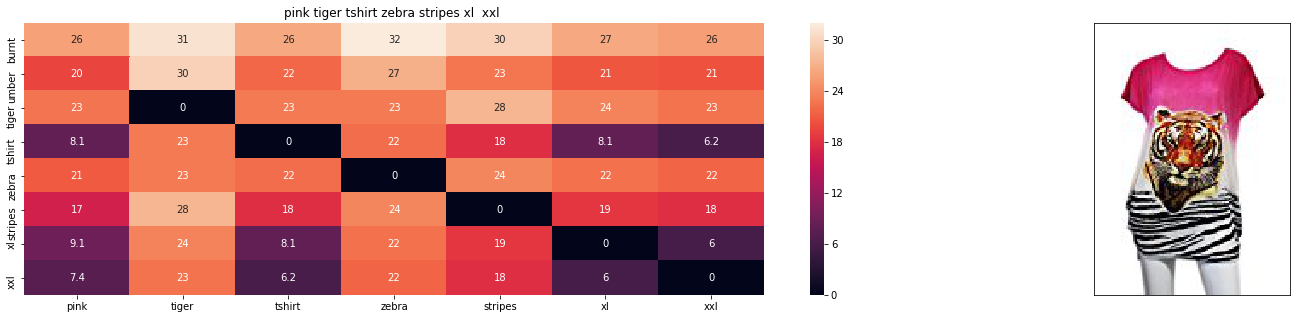

ASIN : B00JXQASS6
Brand : Si Row
Color : Pink
euclidean distance from input : 4.152921926086053


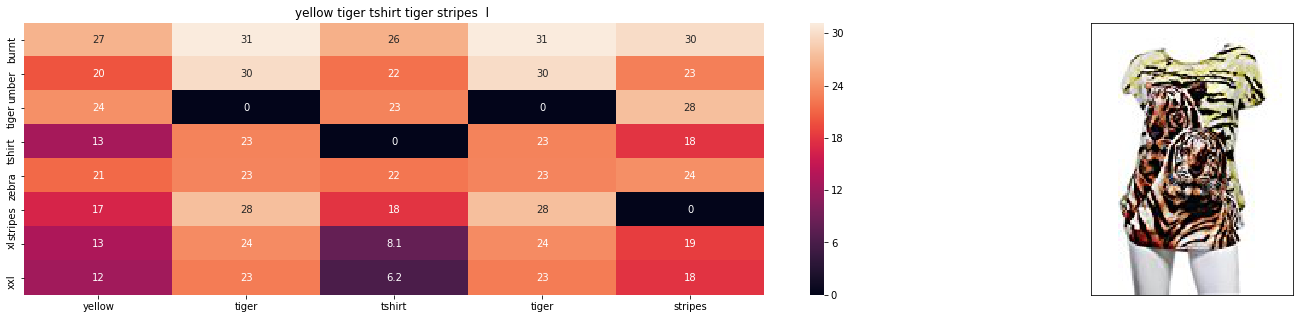

ASIN : B00JXQCUIC
Brand : Si Row
Color : Yellow
euclidean distance from input : 4.575743631243994


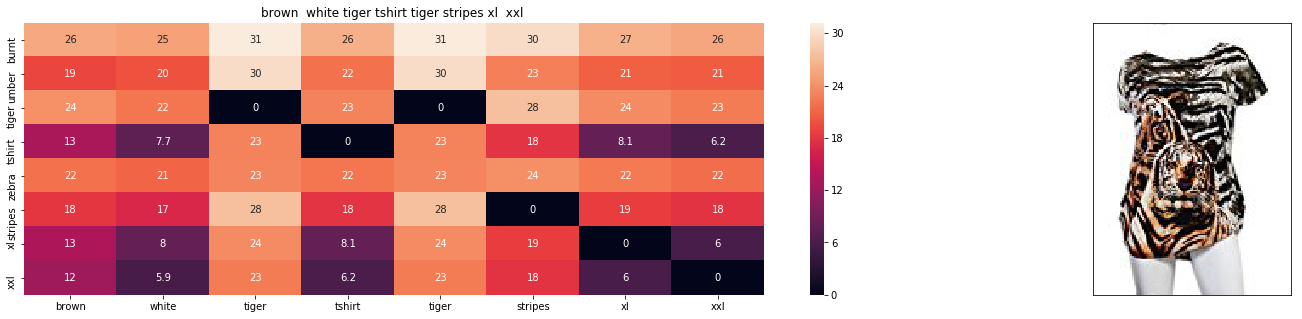

ASIN : B00JXQCWTO
Brand : Si Row
Color : Brown
euclidean distance from input : 4.639908460470346


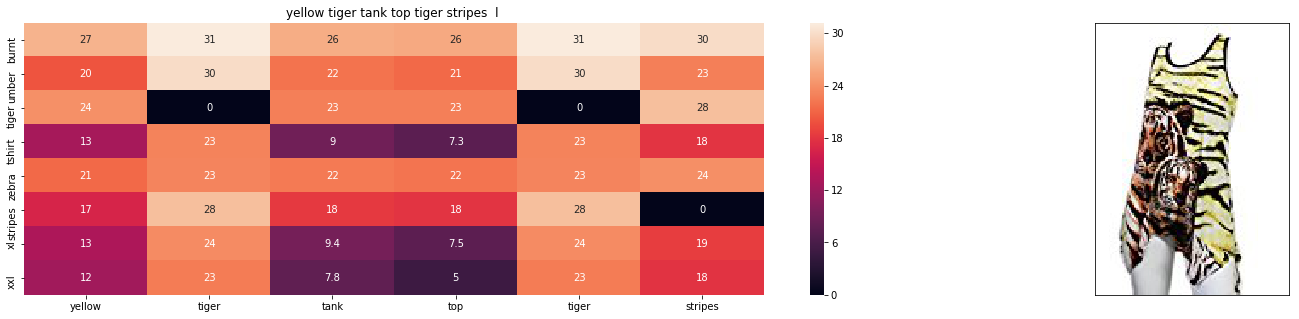

ASIN : B00JXQAUWA
Brand : Si Row
Color : Yellow
euclidean distance from input : 4.660201725620778


In [29]:
weighted_model(12566, 1, 10, 1, 1, 5)

#### 3. Giving Colour highest weight.

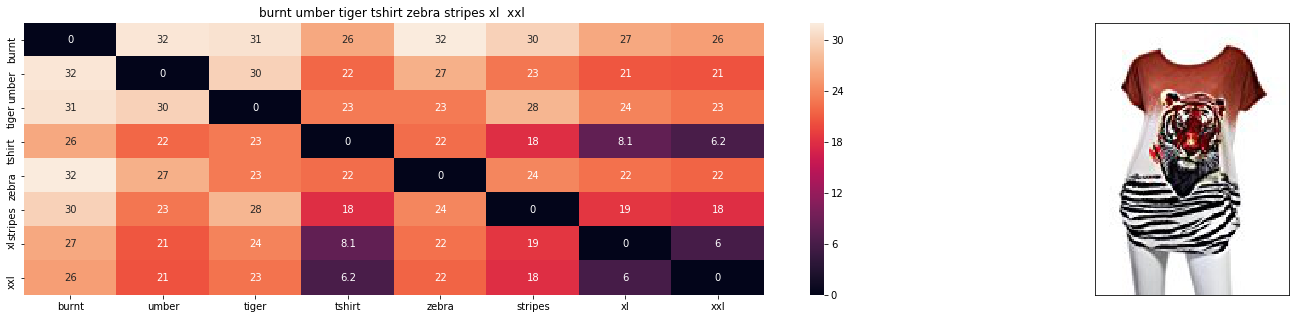

ASIN : B00JXQB5FQ
Brand : Si Row
Color : Brown
euclidean distance from input : 0.0038244957462526285


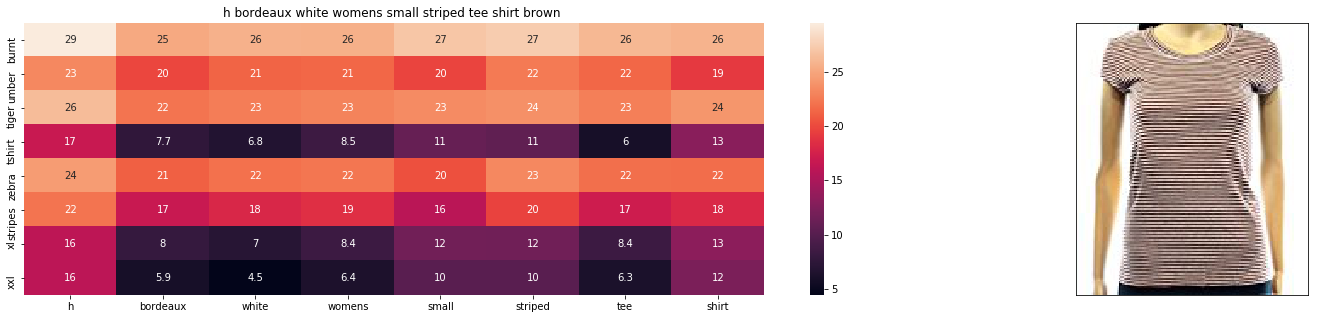

ASIN : B072BVB47Z
Brand : H By Bordeaux
Color : Brown
euclidean distance from input : 4.217422888829158


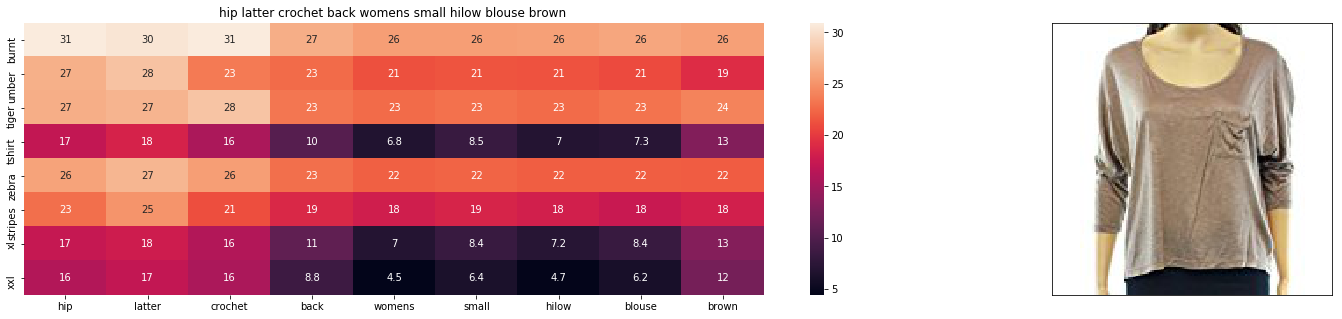

ASIN : B074MJN1K9
Brand : Hip
Color : Brown
euclidean distance from input : 4.275193794514387


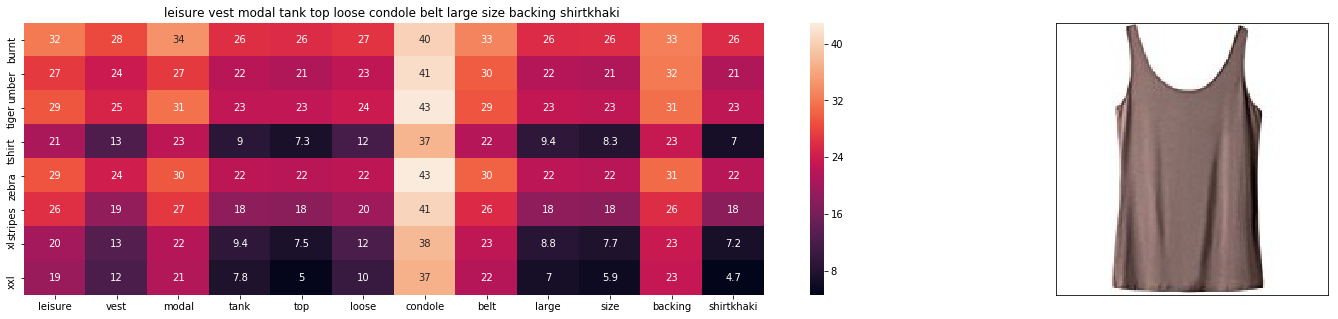

ASIN : B014OUHUZY
Brand : Black Temptation
Color : Brown
euclidean distance from input : 4.488374196566069


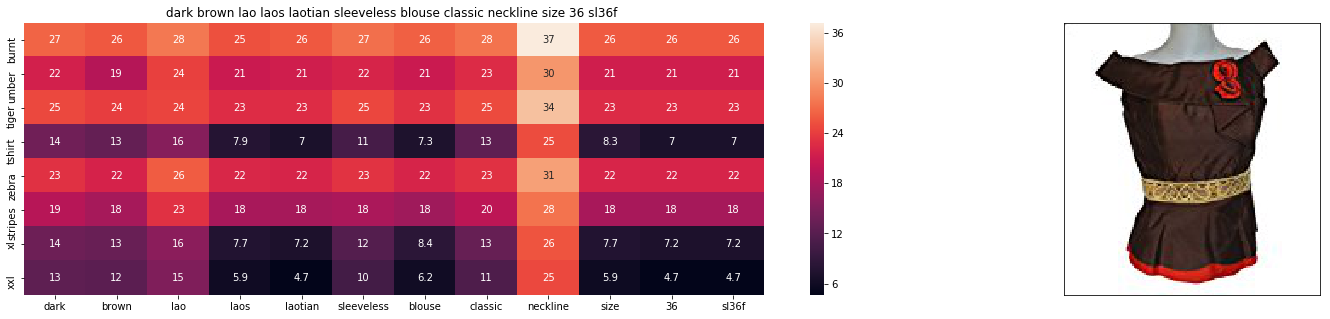

ASIN : B074J7BCYM
Brand : Nanon
Color : Brown
euclidean distance from input : 4.601975544239729


In [30]:
weighted_model(12566, 1, 1, 10, 1, 5)

#### 4. Giving Image highest weight.

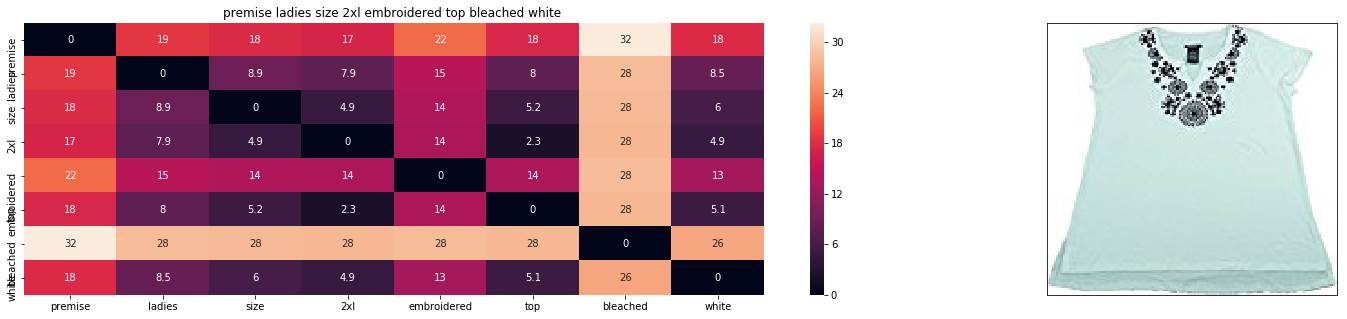

ASIN : B01M0IDUCV
Brand : Premise
Color : Bleached White
euclidean distance from input : 0.8576903207628312


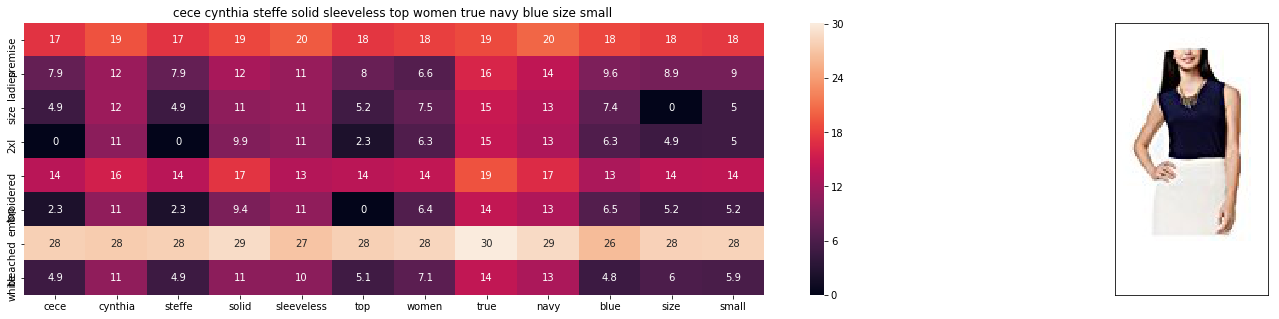

ASIN : B01N4NQ7LX
Brand : CeCe by Cynthia Steffe
Color : True Navy
euclidean distance from input : 24.048377078432374


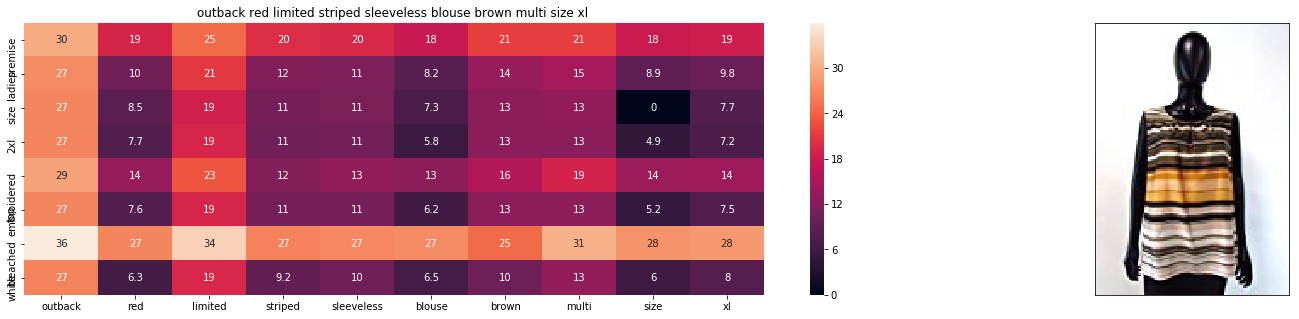

ASIN : B01IU645VU
Brand : Outback Red
Color : Brown Stripe
euclidean distance from input : 32.5558202450092


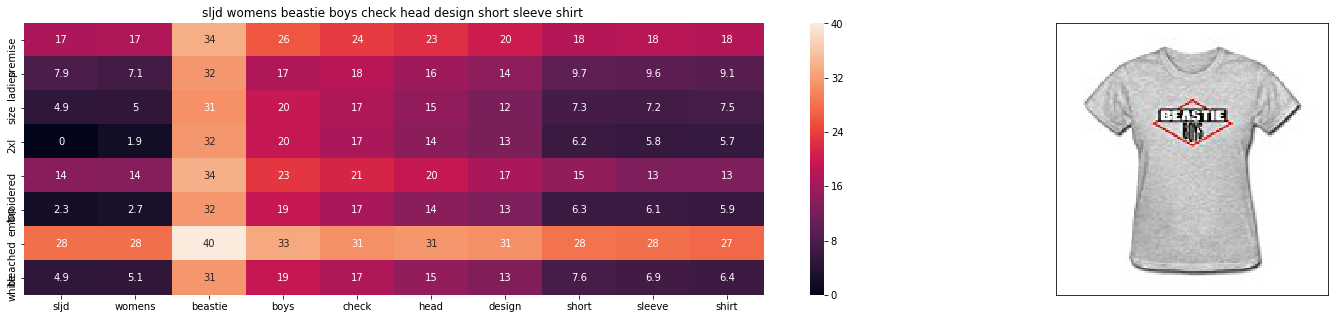

ASIN : B01FQLKKMK
Brand : SLJD
Color : Grey
euclidean distance from input : 34.72779547676499


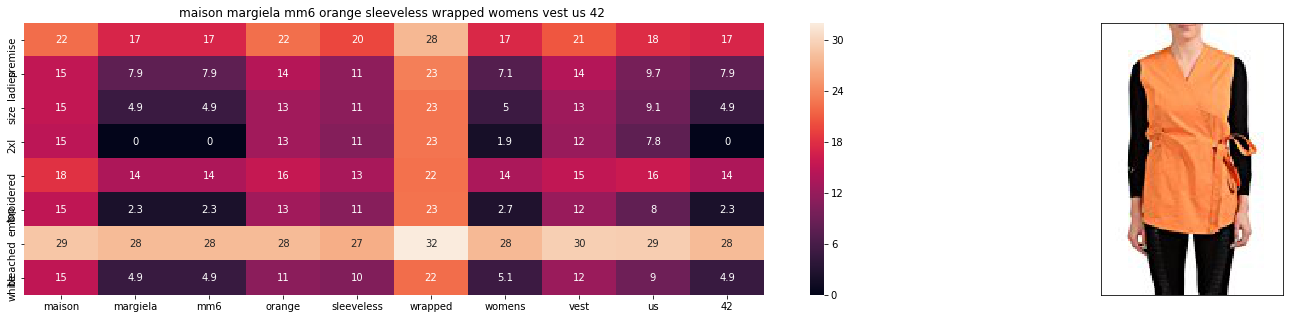

ASIN : B01MXI5L4G
Brand : Maison Margiela MM6
Color : Orange
euclidean distance from input : 37.336125345666865


In [194]:
weighted_model(12566, 1, 1, 1, 10, 5)

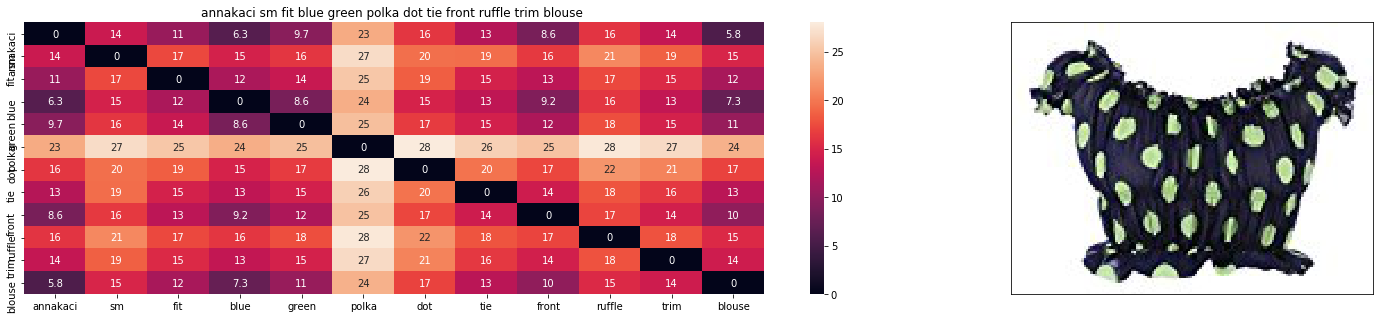

ASIN : B00KLHUIBS
Brand : Anna-Kaci
Color : Blue/Green
euclidean distance from input : 0.0


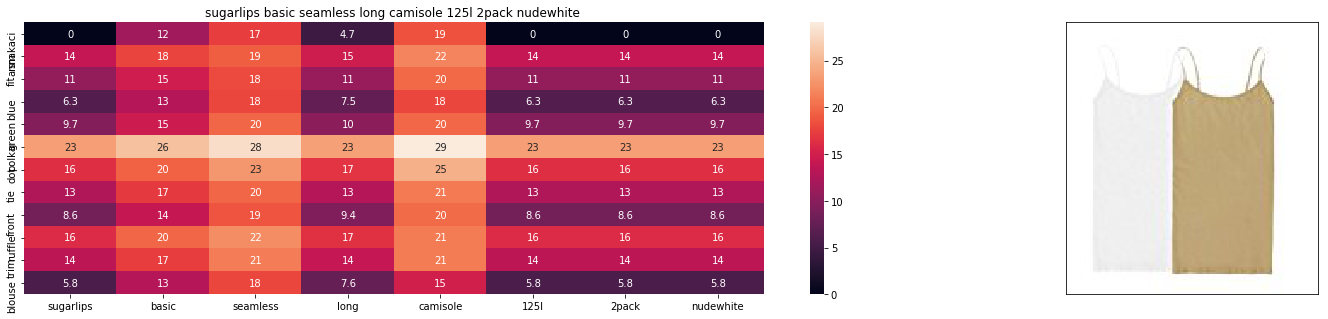

ASIN : B01D9B49LW
Brand : Sugar Lips
Color : 2PACK: NUDE/WHITE
euclidean distance from input : 17.09374312001557


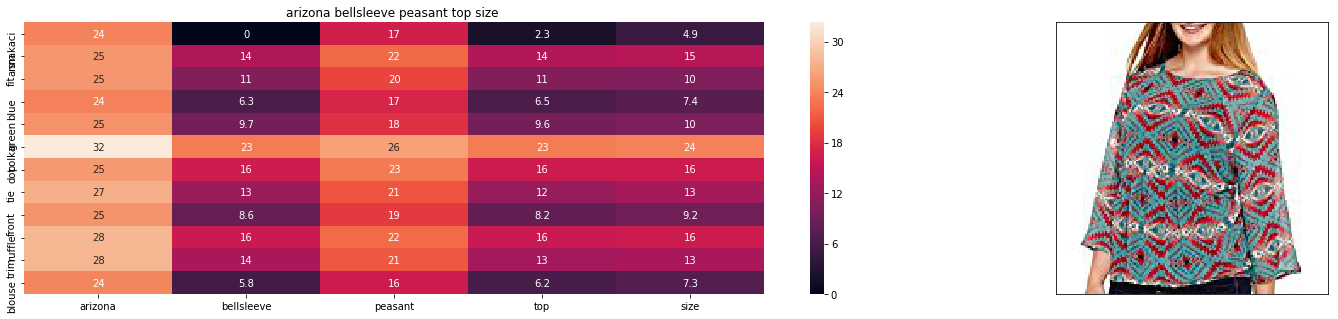

ASIN : B01LY1Z8IY
Brand : AriZona
Color : Multi-color
euclidean distance from input : 18.812145849931962


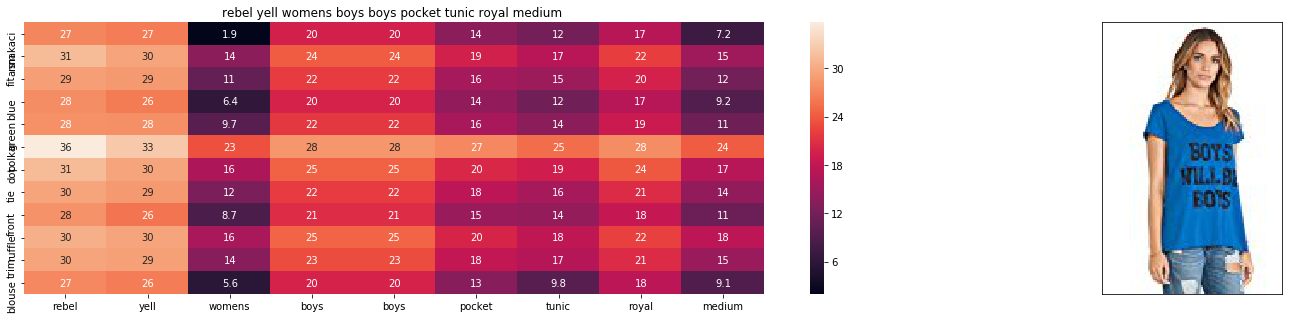

ASIN : B01CT4G42M
Brand : Rebel Yell
Color : Royal
euclidean distance from input : 19.628112859549695


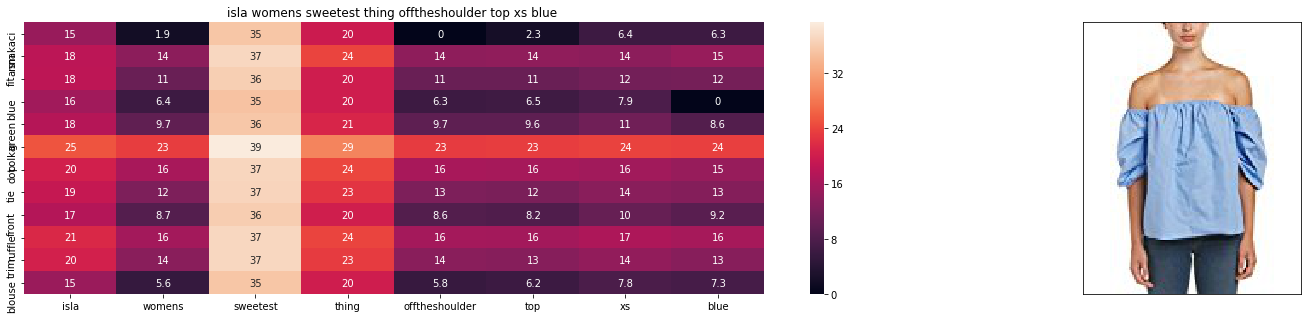

ASIN : B074MGFYFC
Brand : Isla
Color : Pale Blue
euclidean distance from input : 19.75442283395446


In [34]:
weighted_model(931, 1, 1, 1, 10, 5)

Looking at the results, Image based seems to perform the worst. Can't identify the reason for it.

**Edit:** Below are changes made from previous submission

Made changes, now using <br>
"image_features[i_asins.index(data['asin'].iloc[doc_id])]"  <br>
to locate the corresponding index of image vector.  <br>
instead of   "image_features[doc_id]" <br>
It seems right but still something's wrong.

## Writing own functions to show recomended products.

In [19]:
from IPython.display import display, Image

### Model 1: Uses only 'Title' using idf-word2vec.

In [165]:
def model_1(doc_id, n_res):
    '''
        First model using only TITLE feature, purely text based recommendary system.
        Two techniques could be used here, 
            Bag-of-Words: Simple text to vector technique storing the counts of words occuring in a title.
            Word-to-Vec: State of the art technique for text features, which accounts for semantic meaning of words too.
        Here, we use Word2Vec model trained by Google-News Corpus which is openly available for use, by Google.
        IDF weights applied to w2v vecors.
    '''
    
    # Calculating Euclidian Distances of given title from others.
    title_dist = pairwise_distances(title_features, title_features[doc_id].reshape(1,-1))
    
    # Arrange the calculated distances in order.
    # Get arranged index of docs closest to given doc.  We store only top n_res docs.
    title_dist_sort = title_dist.flatten().argsort()[:n_res]
    
    # Display the results.
    for res in title_dist_sort:
        img = '16k_images/'+data['asin'].iloc[res]+'.jpeg'
        display(Image(filename = img,width = 200, height=200 ))
        print('ID: ', data['asin'].iloc[res])
        print('Euclidain dist: ', title_dist.flatten()[res])


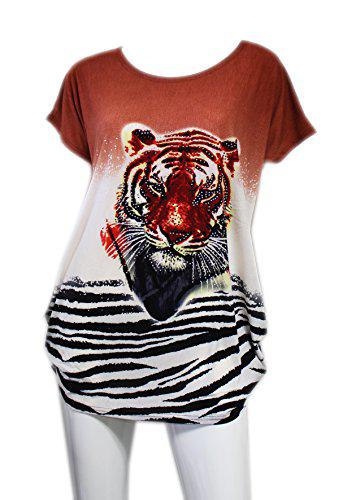

ID:  B00JXQB5FQ
Euclidain dist:  0.0055242716


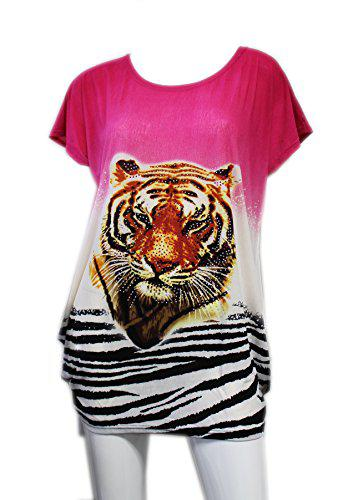

ID:  B00JXQASS6
Euclidain dist:  4.0638876


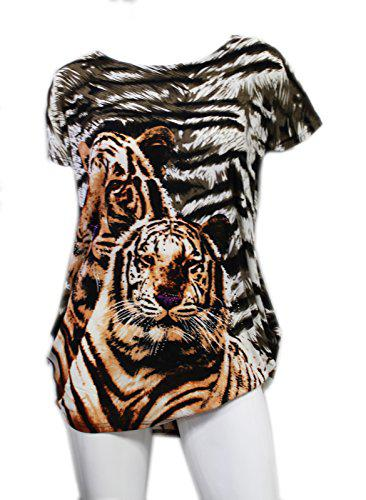

ID:  B00JXQCWTO
Euclidain dist:  4.770943


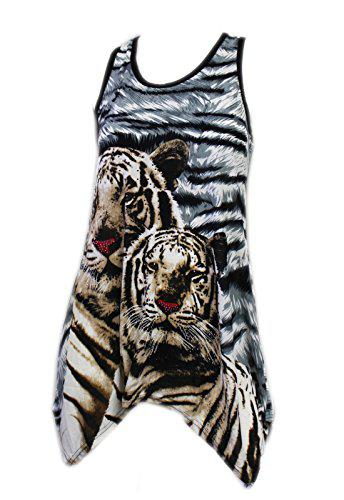

ID:  B00JXQAFZ2
Euclidain dist:  5.360161


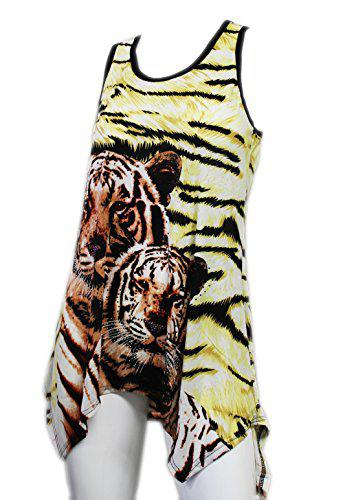

ID:  B00JXQAUWA
Euclidain dist:  5.689523


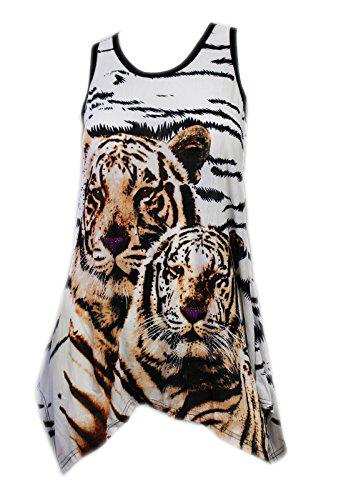

ID:  B00JXQAO94
Euclidain dist:  5.693022


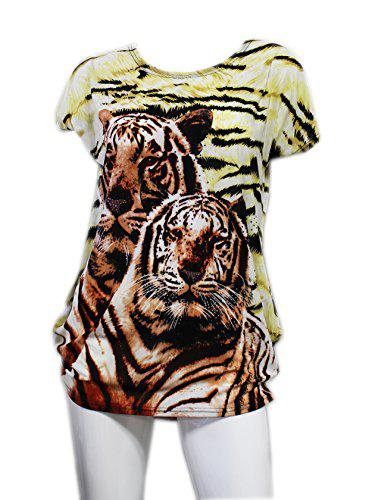

ID:  B00JXQCUIC
Euclidain dist:  5.893444


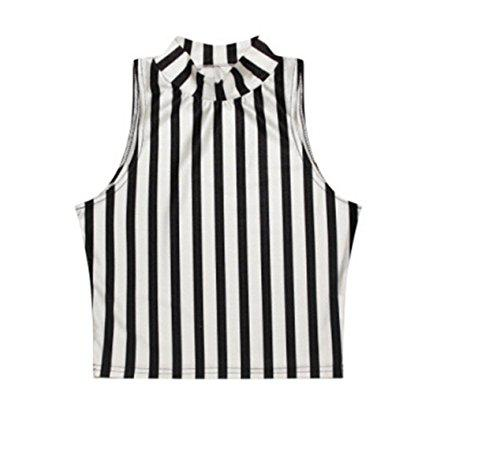

ID:  B015H41F6G
Euclidain dist:  6.13299


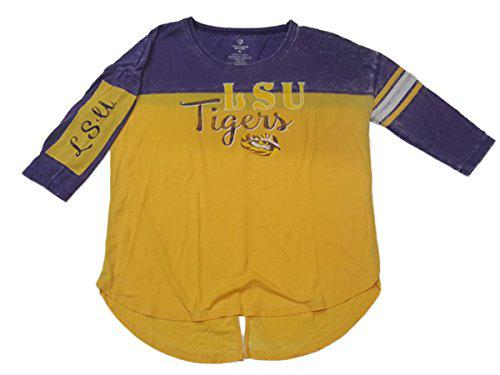

ID:  B073R5Q8HD
Euclidain dist:  6.2567058


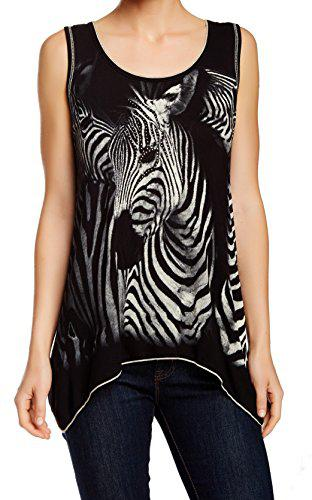

ID:  B074P8MD22
Euclidain dist:  6.3922043


In [171]:
model_1(12566,10)

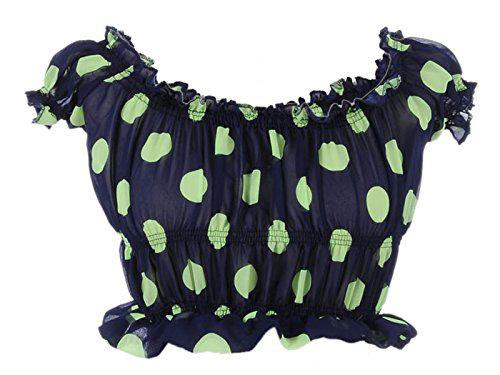

ID:  B00KLHUIBS
Euclidain dist:  0.0


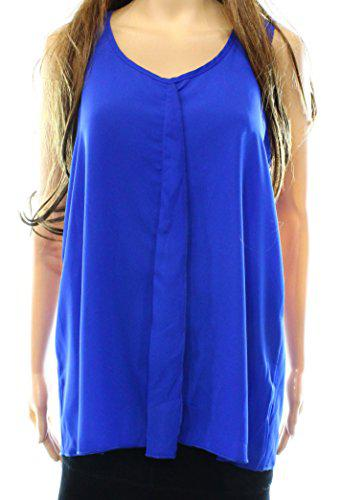

ID:  B072VHTT1D
Euclidain dist:  3.304624


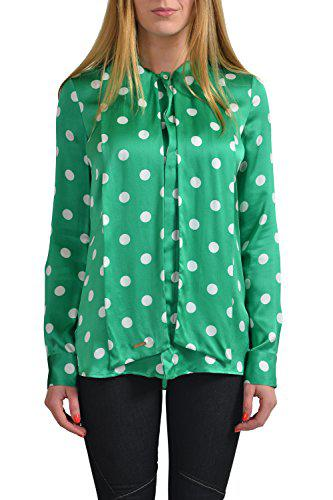

ID:  B01AYBH28M
Euclidain dist:  3.3703344


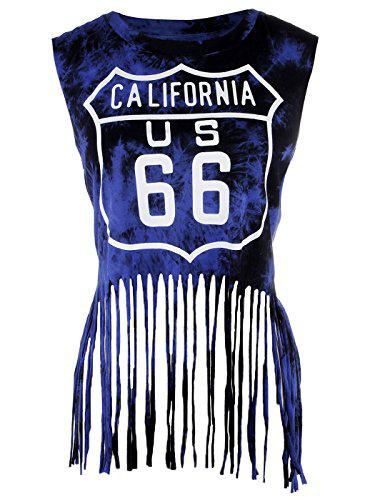

ID:  B00YQ8S4K0
Euclidain dist:  3.419353


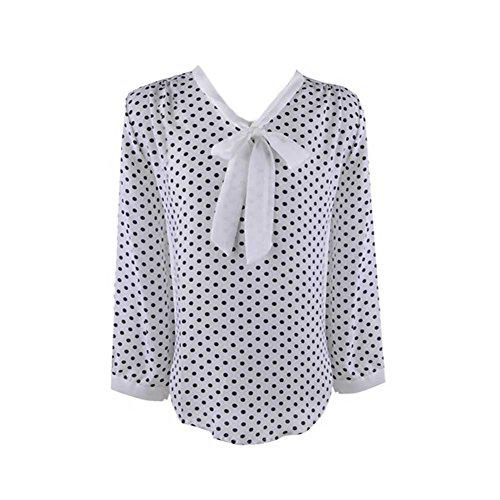

ID:  B00ZD1LI16
Euclidain dist:  3.4255984


In [169]:
model_1(931,5)

### Model 2: Uses weighted values of "Colour, brand and Title".

In [174]:
def model_2(doc_id,w1,w2,w3,n_res):
    '''
        Model using "Colors and Brands" as extra features along with TITLE.
    '''
    
    # Calculating Euclidian Distances of given title from others.
    color_dist = pairwise_distances(color_features, color_features[doc_id])
    brand_dist = pairwise_distances(brand_features, brand_features[doc_id])
    title_dist = pairwise_distances(title_features, title_features[doc_id].reshape(1,-1))
    vec_dist = (w1*color_dist + w2*brand_dist + w3*title_dist)/(w1 + w2 + w3)
    
    # Arrange the calculated distances in order.
    # Get arranged index of docs closest to given doc.  We store only top n_res docs.
    top_docs = vec_dist.flatten().argsort()[:n_res]
    
    # Display the results.
    for res in top_docs:
        img = '16k_images/'+data['asin'].iloc[res]+'.jpeg'
        display(Image(filename = img,width = 200, height=200 ))
        print('ID: ', data['asin'].iloc[res])
        print('Euclidain dist: ', vec_dist.flatten()[res])


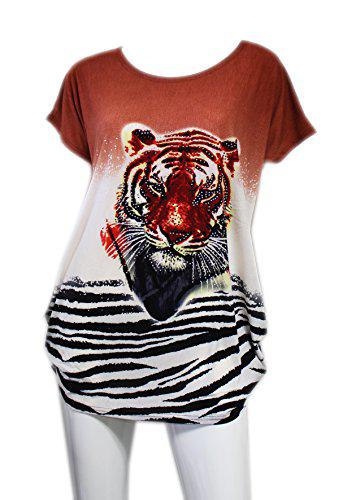

ID:  B00JXQB5FQ
Euclidain dist:  0.0018414238778253396


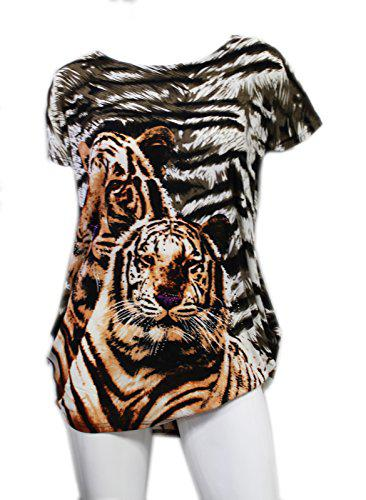

ID:  B00JXQCWTO
Euclidain dist:  1.5903143882751465


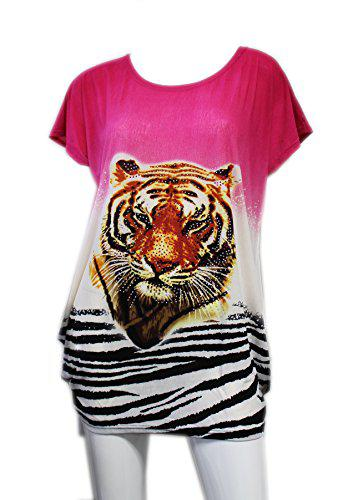

ID:  B00JXQASS6
Euclidain dist:  1.8260337195011553


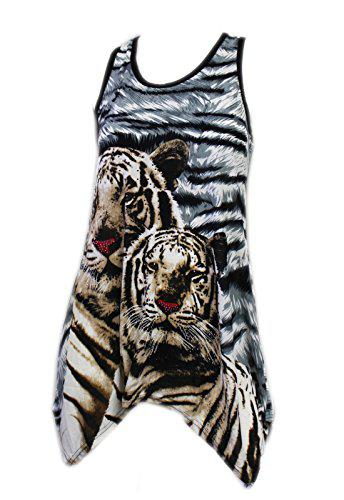

ID:  B00JXQAFZ2
Euclidain dist:  2.258124796669938


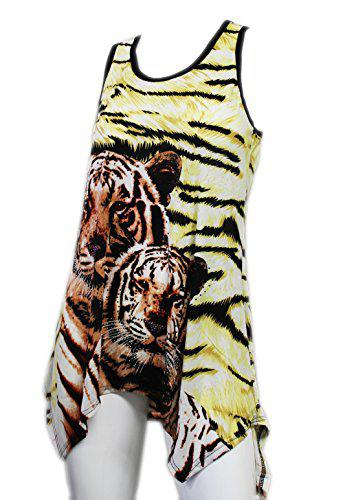

ID:  B00JXQAUWA
Euclidain dist:  2.3679122608117837


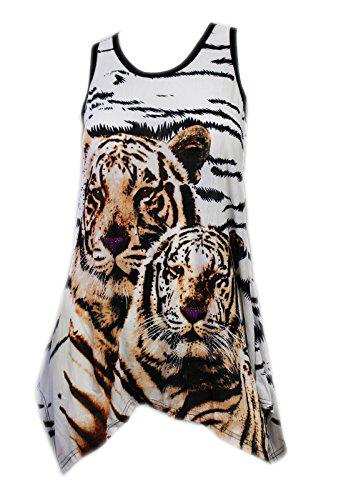

ID:  B00JXQAO94
Euclidain dist:  2.369078445555029


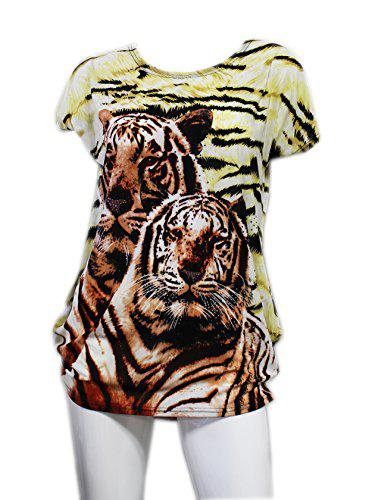

ID:  B00JXQCUIC
Euclidain dist:  2.4358858745507974


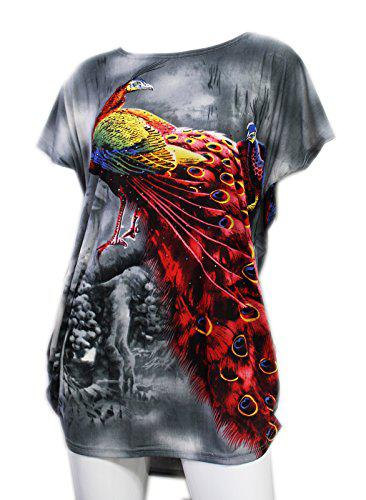

ID:  B00JXQCFRS
Euclidain dist:  2.752541192493099


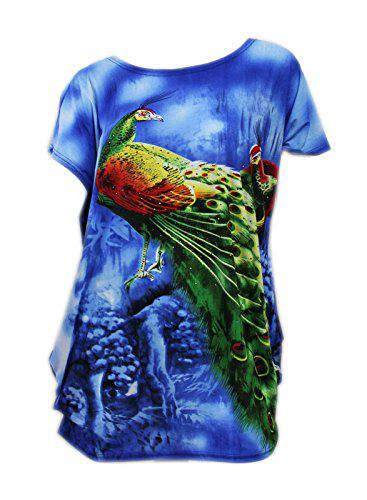

ID:  B00JXQC8L6
Euclidain dist:  2.8026000341984214


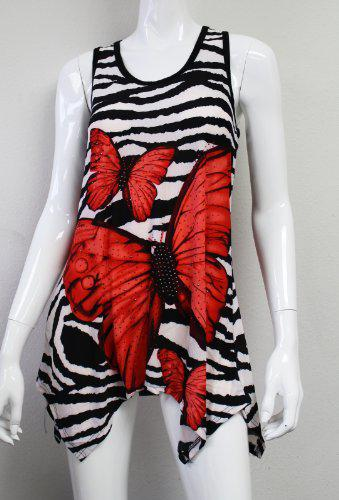

ID:  B00JV63CW2
Euclidain dist:  2.8577243170353355


In [175]:
model_2(12566,1,1,1,10)

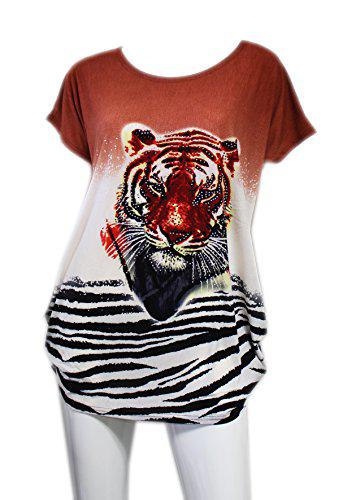

ID:  B00JXQB5FQ
Euclidain dist:  0.0004603559694563349


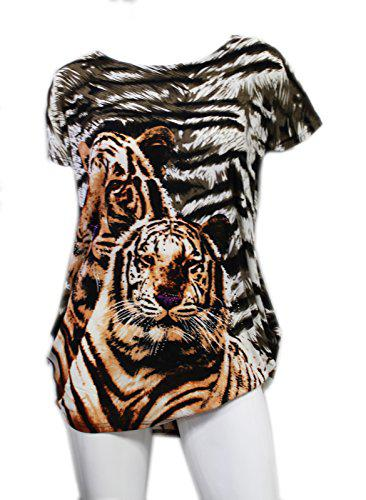

ID:  B00JXQCWTO
Euclidain dist:  0.3975785970687866


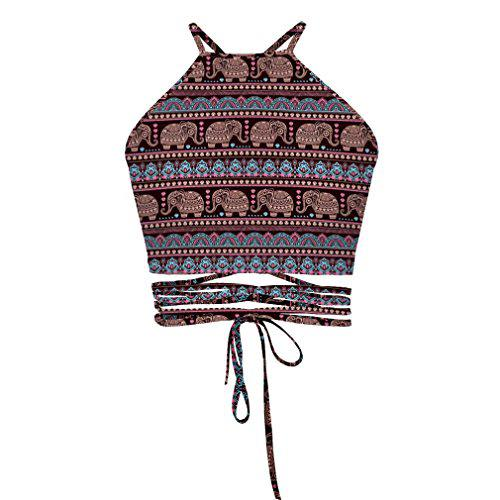

ID:  B01ER184O6
Euclidain dist:  0.7158013906158879


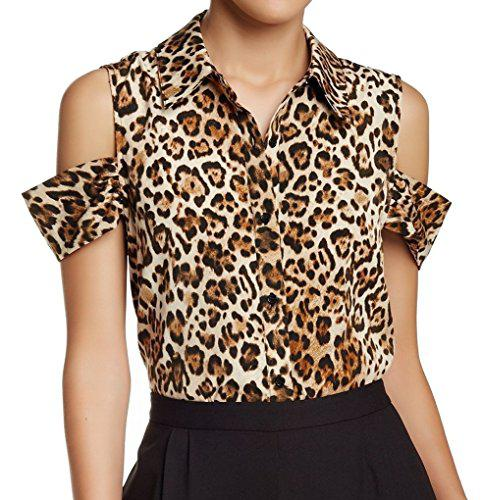

ID:  B01LZ7BQ4H
Euclidain dist:  0.7421121523855004


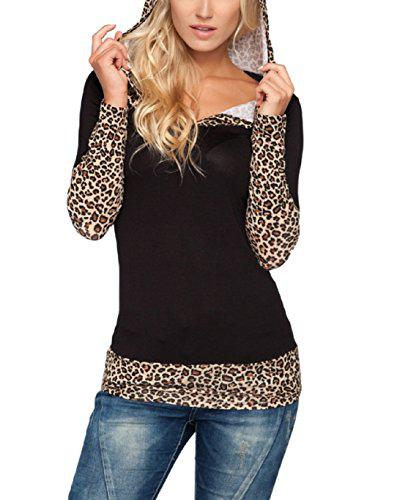

ID:  B01KJUM6JI
Euclidain dist:  0.7429659293172631


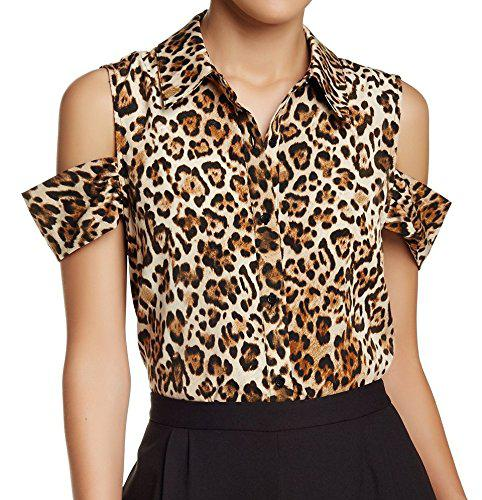

ID:  B01M06V4X1
Euclidain dist:  0.7511460707662377


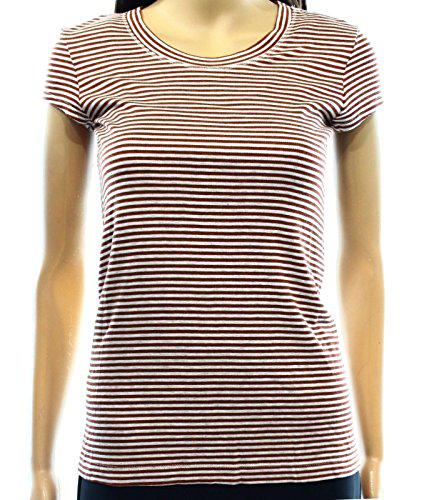

ID:  B072BVB47Z
Euclidain dist:  0.7610875368118286


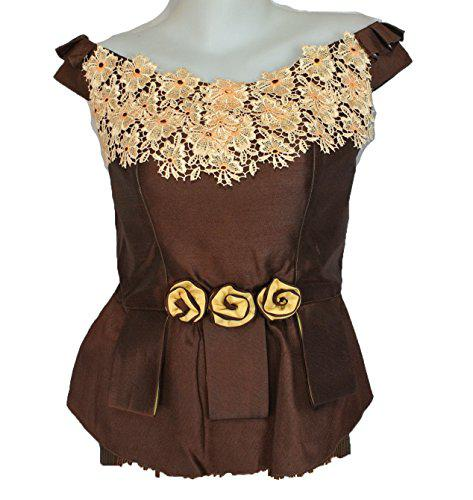

ID:  B074J48RGW
Euclidain dist:  0.7620165671982243


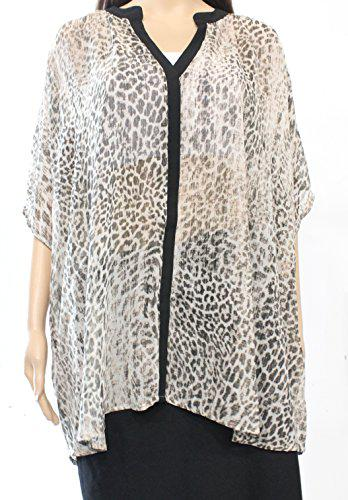

ID:  B074MH886R
Euclidain dist:  0.7628871526398137


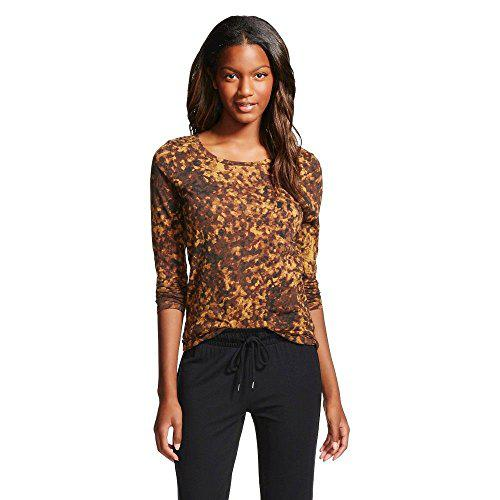

ID:  B01M5KO072
Euclidain dist:  0.7661480432826155


In [176]:
model_2(12566,10,1,1,10)

### Model 3: Uses only "Image"  as our feature.

In [190]:
def model_3(doc_id,n_res):
    '''
        Model using Image visuals only.
        Images is converted into vector using CNN- VGG16.
    '''
    
    # Calculating Euclidian Distances of given title from others.
    img_dist = pairwise_distances(image_features, image_features[i_asins.index(data['asin'].iloc[doc_id])].reshape(1,-1))
    
    # Arrange the calculated distances in order.
    # Get arranged index of docs closest to given doc.  We store only top n_res docs.
    top_docs = img_dist.flatten().argsort()[:n_res]
    
    # Display the results.
    for res in top_docs:
        img = '16k_images/'+i_asins[res]+'.jpeg'
        display(Image(filename = img,width = 200, height=200 ))
        print('ID: ', data['asin'].iloc[res])
        print('Euclidain dist: ', img_dist.flatten()[res])

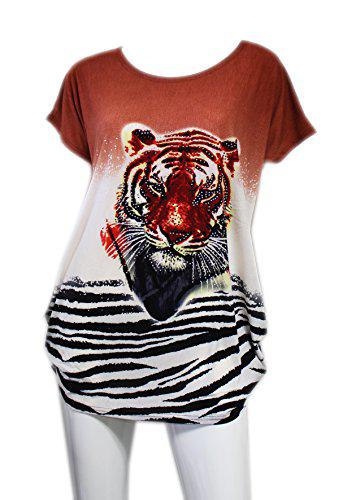

ID:  B01M0IDUCV
Euclidain dist:  0.0


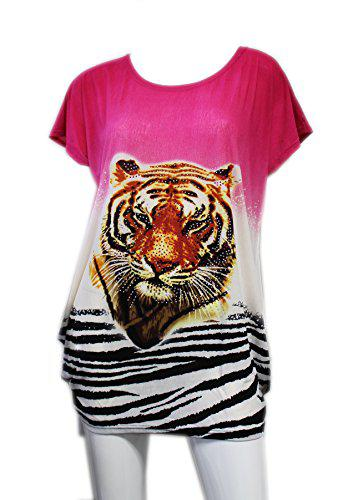

ID:  B01N4NQ7LX
Euclidain dist:  30.050104


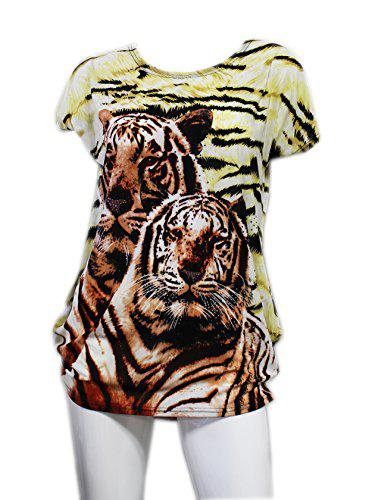

ID:  B01IU645VU
Euclidain dist:  41.261078


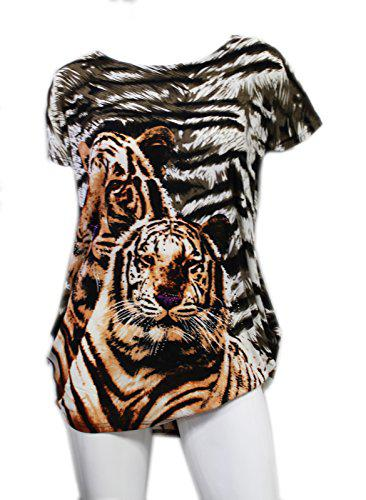

ID:  B01FQLKKMK
Euclidain dist:  44.000156


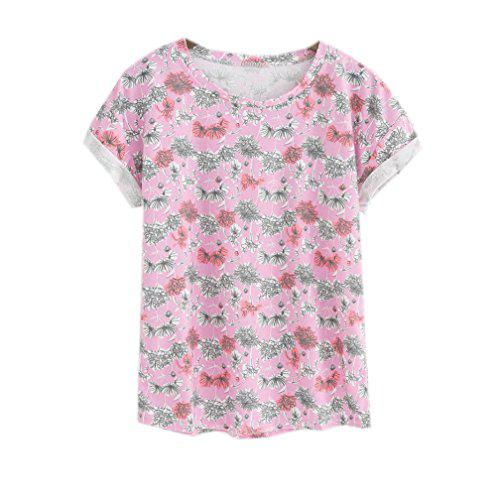

ID:  B01MXI5L4G
Euclidain dist:  47.382523


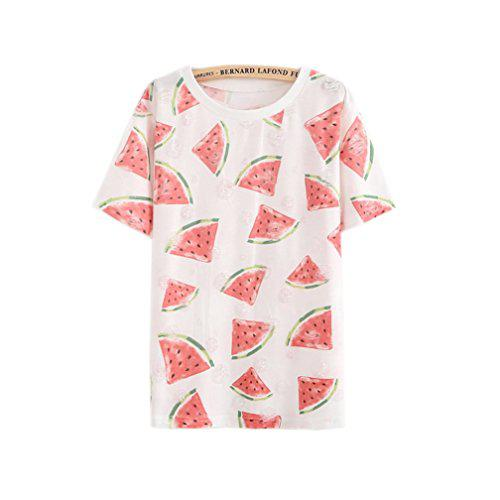

ID:  B00K77AN5S
Euclidain dist:  47.718403


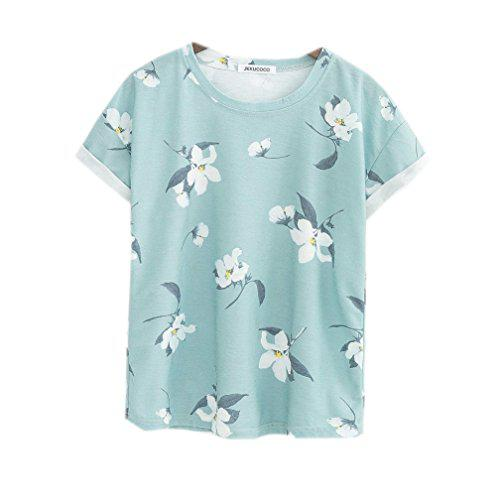

ID:  B01MG83UB4
Euclidain dist:  47.902122


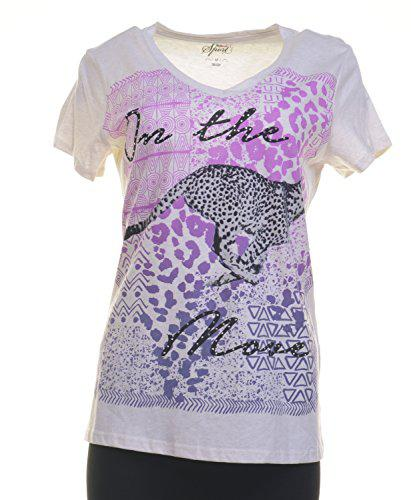

ID:  B00YC92VRU
Euclidain dist:  48.046516


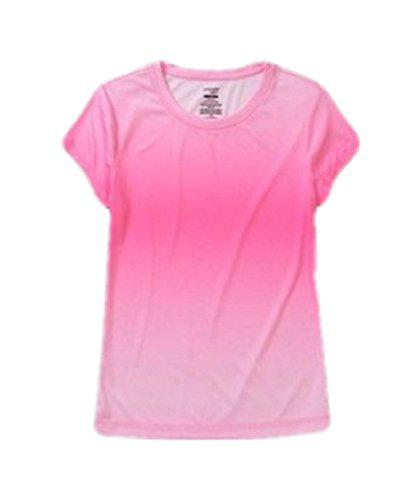

ID:  B071LMW4YG
Euclidain dist:  48.101906


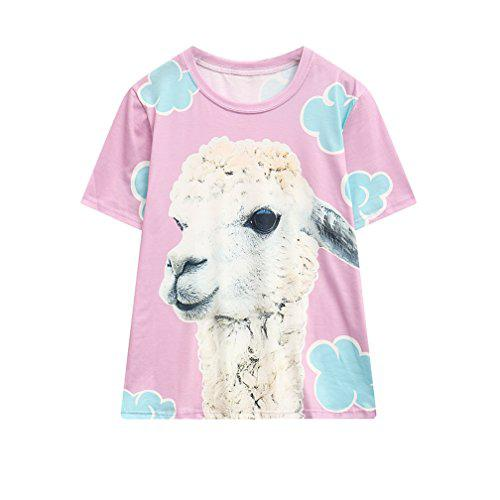

ID:  B01MQWKWME
Euclidain dist:  48.118877


In [191]:
model_3(12566,10)

In [164]:
#testing

In [181]:
i_asins.index(data['asin'].iloc[12566])

1416

In [184]:
data['asin'].iloc[12566]

'B00JXQB5FQ'

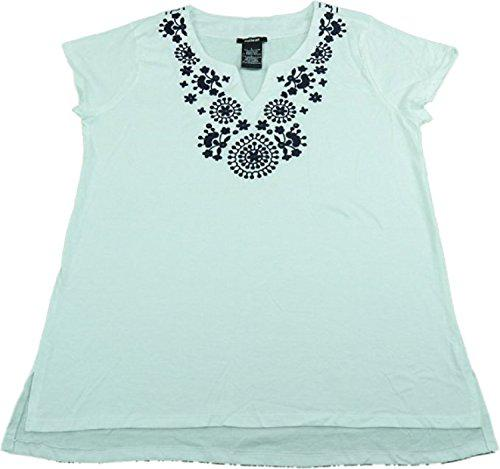

In [182]:
img = '16k_images/'+data['asin'].iloc[1416]+'.jpeg'
display(Image(filename=img))

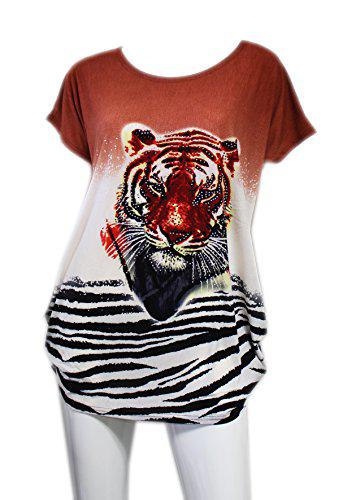

In [189]:
img5 = '16k_images/'+i_asins[1416]+'.jpeg'
display(Image(filename=img5))

In [26]:
t_d = pairwise_distances(title_features, title_features[12566].reshape(1,-1))

In [73]:
t_d.flatten().argsort()

array([12566, 14089, 14072, ..., 13660,  1520, 14876], dtype=int64)

In [44]:
t_d.flatten().argsort()

array([12566, 14089, 14072, ..., 13660,  1520, 14876], dtype=int64)

In [52]:
t_d.flatten().argsort()[100:120]

array([12343, 15638, 14357,  3016, 10063, 10554, 10238,  9583, 15533,
        4517, 12065,  4025,   951,  4040,  8831, 12568,  6749,  8934,
        3115,  6348], dtype=int64)

In [46]:
t_d[12566]

array([0.00552427], dtype=float32)

In [47]:
t_d[14089]

array([4.0638876], dtype=float32)

In [55]:
t_d[6300]

array([8.272659], dtype=float32)

In [50]:
t_d.flatten()

array([8.378794, 8.583409, 8.621728, ..., 9.088225, 8.475003, 8.273877],
      dtype=float32)

In [56]:
t_ds = np.sort(t_d.flatten())

In [57]:
t_ds

array([5.5242716e-03, 4.0638876e+00, 4.7709432e+00, ..., 1.5200596e+01,
       1.5235990e+01, 1.5486519e+01], dtype=float32)

In [60]:
t_ds.argsort()[:10]

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int64)

In [71]:
t_d[14089] == t_ds.count()


AttributeError: 'numpy.ndarray' object has no attribute 'count'

In [62]:
t_ds[1]

4.0638876

In [117]:
float(t_d.flatten()[12566])

TypeError: float() takes at most 1 argument (2 given)

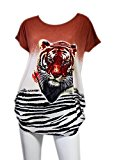

In [75]:
display(Image(data['medium_image_url'].iloc[12566]))

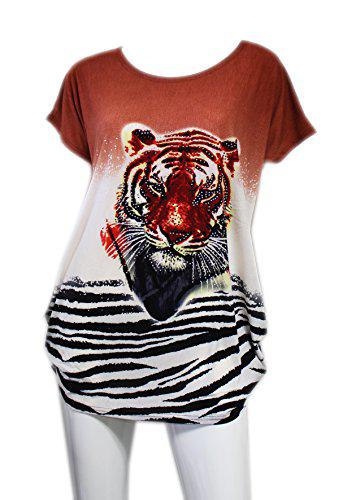

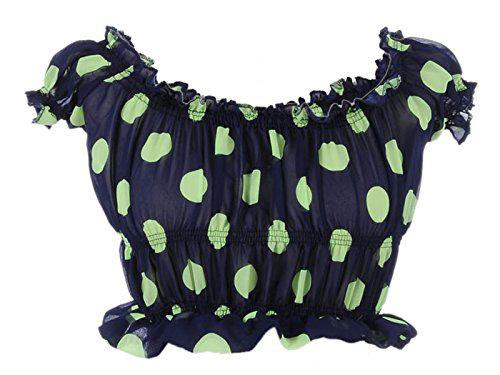

In [104]:
img = '16k_images/'+data['asin'].iloc[12566]+'.jpeg'
img1 = '16k_images/'+data['asin'].iloc[931]+'.jpeg'
display(Image(filename = img, width = 200, height=200 ))
display(Image(filename = img1,width = 200, height=200 ))

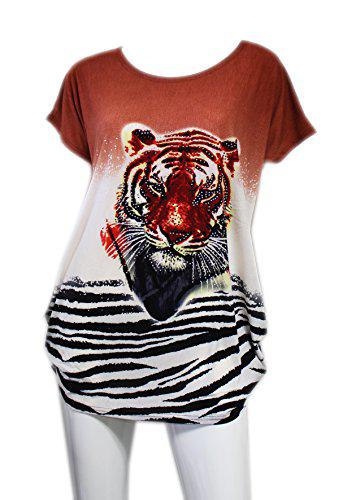

ID:  B00JXQB5FQ
Euclidain dist:  0.0055242716


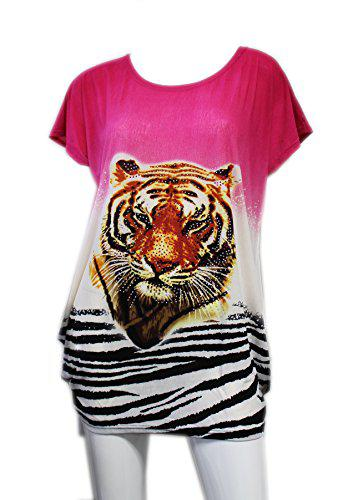

ID:  B00JXQASS6
Euclidain dist:  4.0638876


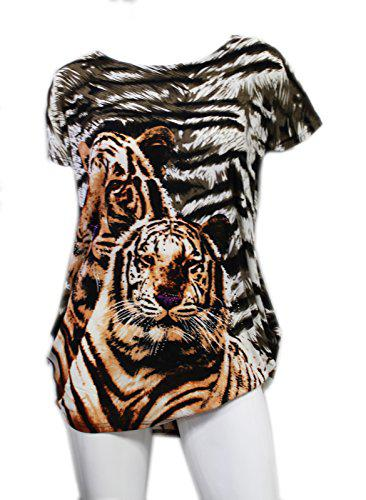

ID:  B00JXQCWTO
Euclidain dist:  4.770943


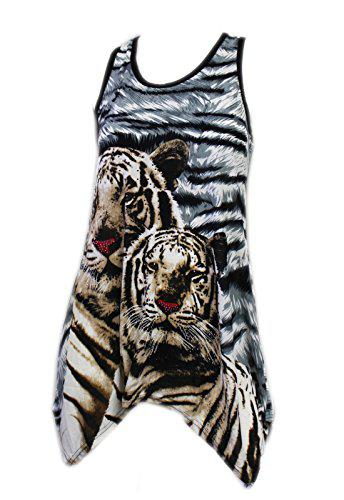

ID:  B00JXQAFZ2
Euclidain dist:  5.360161


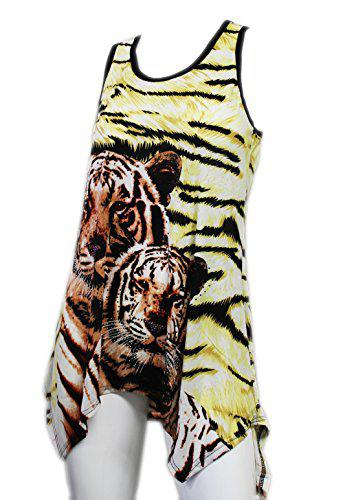

ID:  B00JXQAUWA
Euclidain dist:  5.689523


In [136]:
model_1(12566,5)

In [139]:
print('<h1>the</h1>')

<h1>the</h1>


In [ ]:
from IPython.display import display, HTML
def make_html(folder, image):
     return '<img src="{}" style="display:inline;margin:1px"/>'
            .format(os.path.join(folder, image))

display(HTML(''.join(make_html(f, x)) for x in files))

In [150]:
from matplotlib.image import imread

from matplotlib.pyplot import axis

IndexError: index 3 is out of bounds for axis 0 with size 3

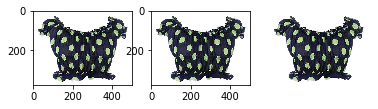

In [157]:
f,ax = plt.subplots(1,3)

for i in range(5):
    ax[i].imshow(imread('16k_images/'+data['asin'].iloc[931]+'.jpeg'), )
    axis('off')

#plt.show() # or display.display(plt.gcf()) if you prefer

In [153]:
![dgf](test.gif "Title")

'[dgf]' is not recognized as an internal or external command,
operable program or batch file.


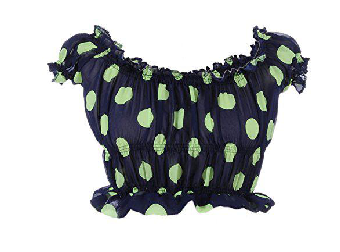

In [163]:
plt.axis('off')
plt.imshow(pimg.open('16k_images/'+data['asin'].iloc[931]+'.jpeg'))


In [160]:
from PIL import Image as pimg

In [193]:
from PIL import Image